In [1]:
import json
import pandas as pd
import numpy as np
import os
import re

In [3]:
#file_dir = "C:\Users\15122\Documents\GitHub\Movies-ETL"

file_dir = os.path.join(r"C:\Users\15122\Documents\GitHub", "Movies-ETL")

print(file_dir)

C:\Users\15122\Documents\GitHub\Movies-ETL


In [4]:
with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [ ]:
len(wiki_movies_raw)

In [ ]:
# First 5 records
#wiki_movies_raw[:5]

In [ ]:
# Some records in the middle
#wiki_movies_raw[3600:3605]

In [5]:
kaggle_path = os.path.join(file_dir, "movies_metadata.csv")
#output: 'C:\\Users\\15122\\Documents\\GitHub\\Movies-ETL\\movies_metadata.csv'
kaggle_metadata = pd.read_csv(kaggle_path, low_memory=False)


ratings_path = os.path.join(file_dir, "ratings.csv")
ratings = pd.read_csv(ratings_path, low_memory=False)


In [ ]:
#ratings.sample()

In [ ]:
#kaggle_metadata.sample()

In [6]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
#wiki_movies_df.head()
#gives 5 rows × 193 columns

In [ ]:
#wiki_movies_df.columns.tolist()

In [ ]:
#[expression for element in source_list]
#[expression for element in source_list if filter_expression]

#if ('Director' in movie or 'Directed by' in movie) 
#and 'imdb_link' in movie
#Execute portion of the process


wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie]
len(wiki_movies)


In [ ]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
               and 'imdb_link' in movie 
               and 'No. of episodes' not in movie]

In [ ]:
#wiki_movies_df[wiki_movies_df['Arabic'].notnull()]

In [ ]:
wiki_movies_df[wiki_movies_df['Arabic'].notnull()]['url']

#columns that hold alternate title data: 
#Also known as, Arabic, Cantonese, Chinese, French, Hangul, Hebrew, Hepburn, Japanese, Literally,  Mandarin, McCune–Reischauer, Original title, Polish,  Revised Romanization, Romanized, Russian, Simplified, Traditional, Yiddish

In [ ]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [ ]:
#45 columns after first function run
#48 after second with condensing column number?

#So many questions.
#Why did the count get list of columns get longer?
#What should my jupyter file look like, since I was supposed to "keep it linear" but didn't know that. 
#Does that mean I should make a new copy of the function and comment out the old?
#Or do I need to physically move cells around, old results, function, new results
#How do I use comments to show linear movement?


In [ ]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

In [ ]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))

wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
#wiki_movies_df.head()


In [ ]:
[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

In [ ]:
[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]

In [ ]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [ ]:
wiki_movies_df.dtypes

In [ ]:
box_office = wiki_movies_df['Box office'].dropna()
len(box_office)

In [ ]:
def is_not_a_string(x):
    return type(x) != str

box_office[box_office.map(is_not_a_string)]
#this is just showing you the non-stringness?

In [ ]:
#lambda function to use in expression that makes all type not a string:
#lambda x: type(x) != str

box_office[box_office.map(lambda x: type(x) != str)]


In [ ]:
#we are finally using "apply" but why only here?
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)


In [ ]:
box_office.tail()

In [ ]:
#working with two main forms of box office data "$123.4 m(/b)illion" (or billion) or "$123,456,789"
# r indicates raw string. Prevents each \ from causing an escape


form_one = r'\$\d+\.?\d*\s*[mb]illion'


box_office.str.contains(form_one, flags=re.IGNORECASE).sum()



In [ ]:
form_two = r'\$\d{1,3}(?:,\d{3})+'

box_office.str.contains(form_two, flags=re.IGNORECASE).sum()

In [ ]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE)

In [ ]:
box_office[~matches_form_one & ~matches_form_two]

In [ ]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)



In [ ]:
# function to handle diff forms of box office and make them uniform
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [ ]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)


In [ ]:
wiki_movies_df['box_office']

In [ ]:
#Drop this later once you clarify that the output above is correct

#wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [ ]:
#now do the same with budgets
budget = wiki_movies_df['Budget'].dropna()
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

In [ ]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

In [ ]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

#perhaps it's just a difference in how the numbers are shown?
#0       20000000.0
#1        6000000.0

#wiki_movies_df['budget'] 

In [ ]:
#drop the original Budget column once reviewed
#wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [ ]:
#clean up release date
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)


In [ ]:
#wiki_movies_df['release_date'] 

In [ ]:
#running time cleaning

running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)



In [ ]:
running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()

In [ ]:
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]


In [ ]:
#just check beginning of "minutes" part

running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()

#now check outliers again
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE) != True]


In [ ]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
#dont run this?

#Coercing error: turn  empty strings into (NaN)
#after,  use fillna() to change all the NaNs to zeros.
#also don't run this?
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

#run all of it. 
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)


In [ ]:
wiki_movies_df['running_time'] 

In [ ]:
#Moving the drop columns into one cell

#wiki_movies_df.drop('Box office', axis=1, inplace=True)
#wiki_movies_df.drop('Budget', axis=1, inplace=True)

#wiki_movies_df.drop('Running time', axis=1, inplace=True)


In [7]:
#now clean Kaggle, the flat file
#take a look at data types

kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [8]:
#check booleans for non T/F
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [9]:
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# keep rows where the adult column is False, and then drop the adult column.
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')


In [11]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [ ]:
kaggle_metadata['video']

In [12]:
#do we need this?
#kaggle_metadata['video'] == 'True'

#this makes it boolean but also changes the data. What's the point of that?

kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [13]:
kaggle_metadata['video']

#data type is bool but all values are now false? 

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45454, dtype: bool

In [14]:
kaggle_metadata['video'].value_counts()

#why are all false?

False    45454
Name: video, dtype: int64

In [15]:
#numeric columns, to_numeric() with errors=set to 'raise'
#will show data that can't be converted to numbers?

kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')


In [16]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])


In [17]:
kaggle_metadata.dtypes

belongs_to_collection            object
budget                            int32
genres                           object
homepage                         object
id                                int64
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
video                              bool
vote_average                    float64
vote_count                      float64
dtype: object

In [18]:
#Now looking at ratings df from converted ratings.csv

#dataset has so many rows, we need to set the null_counts option to True.
#no explanation about what that does or why it's necessary. Just that one line

ratings.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [19]:
#We'll specify in to_datetime() that the origin is 'unix' and the time unit is seconds.
#how is that specified?

pd.to_datetime(ratings['timestamp'], unit='s')


0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [20]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

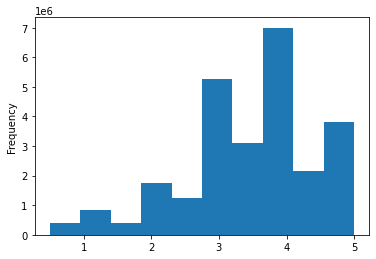

In [22]:
#look at ratings statistics, check for glaring errors
#look at a histogram of the rating distributions
#then use the describe() method to print out some stats on central tendency and spread.

pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

#the number output looks different than the module here too